### Config

In [ ]:
import os, sys
from pathlib import Path
data_dir = Path('./data')
splits_dir = data_dir / 'splits'
splitting_dir = data_dir / 'splitting'
dir = {
    'train': {
        'phishes': splits_dir / 'train' / 'phishing',
        'benigns': splits_dir / 'train' / 'benign'
    },
    'test': {
        'phishes': splits_dir / 'test-before-filtering' / 'phishing',
        'benigns': splits_dir / 'test-before-filtering' / 'benign'
    },
    'nn': {
        'phishes': {
            'url': splitting_dir / 'nn' / 'url_phishes_8_2.pkl',
            'html': splitting_dir / 'nn' / 'html_phishes_16_2.pkl'
        },
        'benigns': {
            'url': splitting_dir / 'nn' / 'url_benigns_8_2.pkl',
            'html': splitting_dir / 'nn' / 'html_benigns_16_2.pkl'
        }
    }
}
seed = 42

srcpath = os.path.abspath(os.path.join('..', 'source'))
sys.path.append(srcpath)

LSH Dimensions: {url: 8, 'html: 16}

Nearest Neighbor Search Radius: 2

### Common Functions

In [9]:
import multiprocessing as mp
import glob
from tqdm import tqdm
import pandas as pd

def load_sample(filename):
    try:
        """Loads a sample from a JSON file"""
        with open(filename, 'r') as fp:
            sample = json.load(fp)
        return sample
    except Exception as e:
        fn = os.path.dirname(filename)
        print(f"Error loading file {fn}. Error: {e}")
        return fn

def load_df(dir):
    nprocs = 72
    path = os.path.join(dir, '*.json')
    data_files = glob.glob(path)
    with mp.Pool(nprocs) as pool:
        data = pool.map(
            load_sample, 
            tqdm(data_files, desc=f"Loading samples of {os.path.basename(dir)}:"), 
            chunksize=10
        )
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'], format='ISO8601')
    # df.target = df.target.str.lower()
    df = df.sort_values(['date', 'sha256']).reset_index(drop=True)

    return df

import matplotlib.pyplot as plt
import seaborn as sns

def time_analysis(class_type, train_df, test_df=None):
    sns.set_theme()

    plt.figure(figsize=(15,5))

    train_bins = 100
    test_bins = 10
    
    sns.histplot(train_df['date'], label=f'Train', kde=False, stat='count', bins=train_bins, alpha=0.6)
    if test_df is not None:
        sns.histplot(test_df['date'], color='orange', label=f'Test', kde=False, stat='count', bins=test_bins, alpha=0.6)
        
        # Add boundary line
        boundary_date = train_df['date'].max()
        plt.axvline(x=boundary_date, color='red', linestyle='--', linewidth=2, label=f'Boundary: {boundary_date.date()}')
    
    plt.title(f'Collection Period Histogram with Train-Test Split {class_type.capitalize()}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

import json
import Levenshtein
from bs4 import BeautifulSoup

def get_html(path):
    with open(path) as f:
        html = json.load(f)
    return html['html']

def get_distance(row):
    test_path = dir['test'][row['class_type']] / f"{row['test_sha256']}.json"
    train_path = dir['train'][row['class_type']] / f"{row['train_sha256']}.json"

    test_html = get_html(test_path)
    train_html = get_html(train_path)

    test_text = BeautifulSoup(test_html, 'html.parser').get_text()
    train_text = BeautifulSoup(train_html, 'html.parser').get_text()

    return Levenshtein.ratio(test_text, train_text)

### Number of cleaned data points before diversity filter

In [ ]:
nums = {
    'train': {
        'phishes': len(list(dir['train']['phishes'].glob('*.json'))),
        'benigns': len(list(dir['train']['benigns'].glob('*.json')))
    },
    'test': {
        'phishes': len(list(dir['test']['phishes'].glob('*.json'))),
        'benigns': len(list(dir['test']['benigns'].glob('*.json')))
    }
}

print(f"Number of cleaned phishing data")
print(f"  Train: {nums['train']['phishes']}")
print(f"  Test: {nums['test']['phishes']}")
print(f"  Test Ratio: {nums['test']['phishes'] / (nums['test']['phishes'] + nums['train']['phishes']):.2f}")
print(f"Number of cleaned benign data")
print(f"  Train: {nums['train']['benigns']}")
print(f"  Test: {nums['test']['benigns']}")
print(f"  Test Ratio: {nums['test']['benigns'] / (nums['test']['benigns'] + nums['train']['benigns']):.2f}")
print(f"Positive Class ratio")
print(f"  Train: {nums['train']['phishes'] / (nums['train']['phishes'] + nums['train']['benigns']):.2f}")
print(f"  Test: {nums['test']['phishes'] / (nums['test']['phishes'] + nums['test']['benigns']):.2f}")

Number of cleaned phishing data
  Train: 232528
  Test: 149721
  Test Ratio: 0.39
Number of cleaned benign data
  Train: 276731
  Test: 119733
  Test Ratio: 0.30
Positive Class ratio
  Train: 0.46
  Test: 0.56


### Phishing

#### Histogram of collection period before diversity filter

Loaded phishes dataframe with shape: (232528, 8)
Loaded phishes dataframe with shape: (149721, 8)


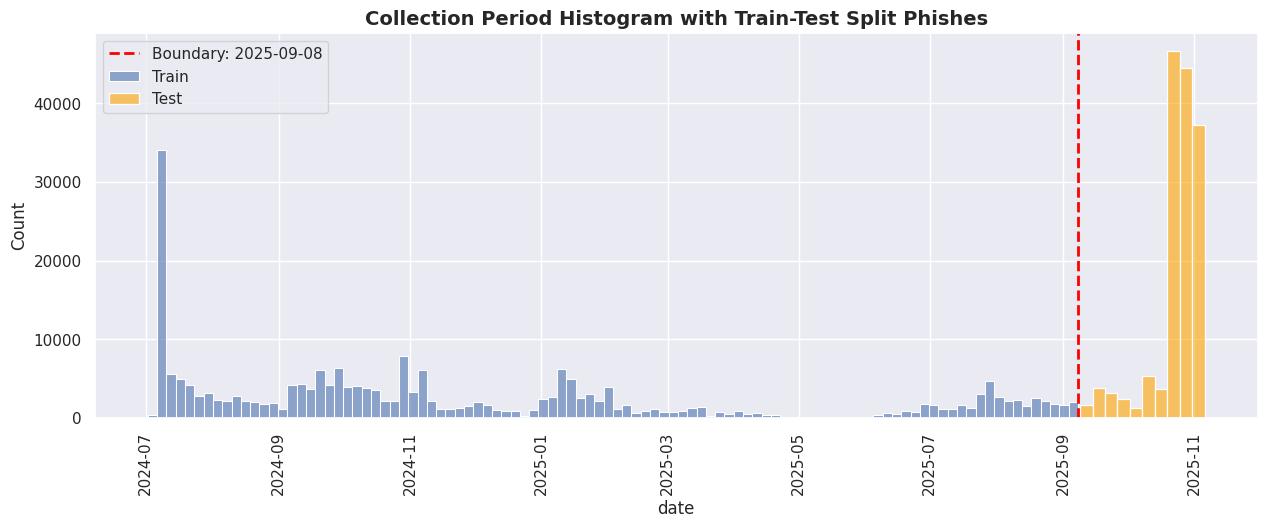

In [ ]:
class_type = 'phishes'
train_df = load_df(dir['train'][class_type])
print(f"Loaded {class_type} dataframe with shape: {train_df.shape}")
test_df = load_df(dir['test'][class_type])
print(f"Loaded {class_type} dataframe with shape: {test_df.shape}")
time_analysis(class_type, train_df, test_df)

#### Nearest train distance distributions

In [11]:
import dill
import pandas as pd

class_type = 'phishes'
test_min_dist = {'url': None, 'html': None}

for feat_type in ['url', 'html']:
    nn_path = dir['nn'][class_type][feat_type]
    with open(nn_path, 'rb') as f:
        min_dist = dill.load(f)
        df = pd.DataFrame.from_dict(min_dist, orient='index', columns=['nearest_train', 'min_distance']).reset_index()
        df = df.rename(columns={'index': 'test_sha256'})
        df['class_type'] = class_type
        test_min_dist[feat_type] = df

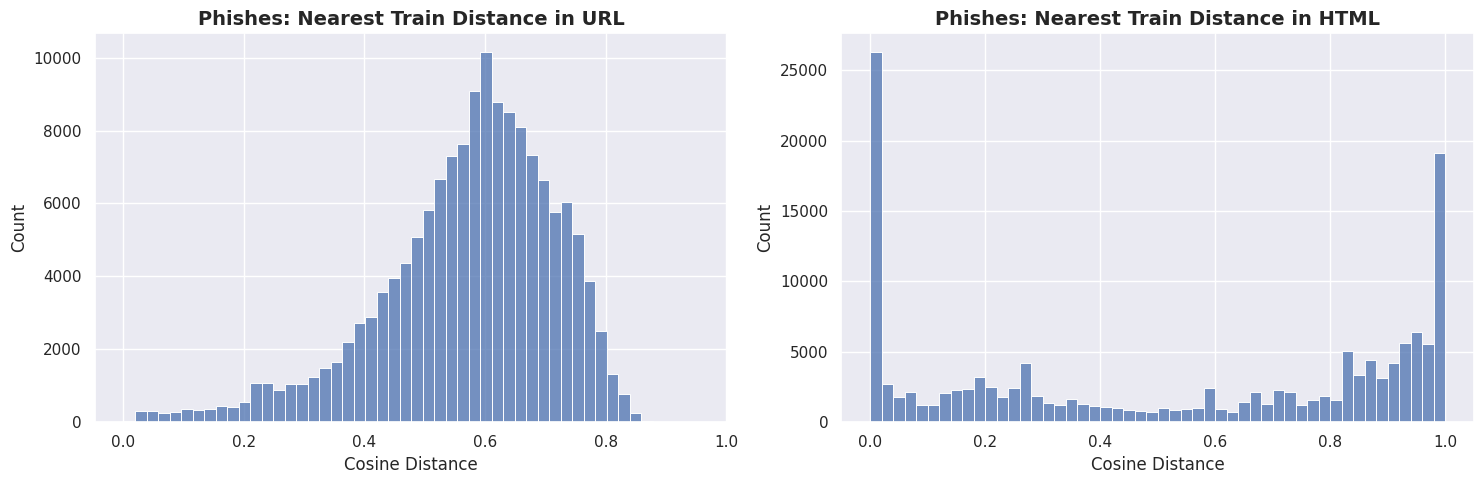

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i, feat_type in enumerate(['url', 'html']):
    sns.histplot(test_min_dist[feat_type]['min_distance'], bins=50, kde=False, stat='count', ax=axes[i])
    axes[i].set_title(f'{class_type.capitalize()}: Nearest Train Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cosine Distance')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Sample html text cosine distances & levenshtein ratios

In [13]:
import pandas as pd

threshs = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
n_samples = 100

samples = None
for thresh in threshs:
    threshold_samples = (
        test_min_dist['html'][test_min_dist['html']['min_distance'] <= thresh]
        .sort_values('min_distance', ascending=False)
        .head(n_samples)[['class_type', 'test_sha256', 'nearest_train', 'min_distance']]
    )
    threshold_samples.columns = ['class_type', 'test_sha256', 'train_sha256', 'cosine_distance']
    threshold_samples['threshold'] = thresh
    threshold_samples['levenshtein_ratio'] = threshold_samples.apply(get_distance, axis=1)
    threshold_samples['median_cosine_distance'] = threshold_samples['cosine_distance'].median()
    threshold_samples['median_levenshtein_ratio'] = threshold_samples['levenshtein_ratio'].median()   

    samples = threshold_samples if samples is None else pd.concat([samples, threshold_samples])

samples = samples.reset_index(drop=True)

samples.to_csv(f'./data/final-{class_type}-test-samples-for-filtering.csv', index=False)

samples

,class_type,test_sha256,train_sha256,cosine_distance,threshold,levenshtein_ratio,median_cosine_distance,median_levenshtein_ratio
0,phishes,7982801ed8a4b8ad3213557013039f5d553e57dc5d1a34...,b9ae0114e2553b0934ed265525b57b9881fd915247779a...,0.099971,0.1,0.658568,0.098749,0.444843
1,phishes,44ad161b01f6facf314ed8fffd4e37b19a05fa00704914...,70f31bf1a55d6ce26c89b98fbccba16670c60c51a83ecc...,0.099970,0.1,0.243331,0.098749,0.444843
2,phishes,50487d80418c8f4a8f3335abb338de562c759aff8faf72...,f236177f28d1aab1ef710ab14939eea7871dd0175281e4...,0.099946,0.1,0.637602,0.098749,0.444843
3,phishes,01b4bf477dba4f516cd97e88dcd1c56dcf555336dea714...,af321f23b1b804d7ca39f5eca58e9c932a94a6089ca6b7...,0.099912,0.1,0.804734,0.098749,0.444843
4,phishes,6a1ef90c5bade8608f79332062d5caf595c7c70162c672...,a2b1092f87c84a11db49d015b785d40ac02d37a853fc98...,0.099893,0.1,0.441287,0.098749,0.444843
...,...,...,...,...,...,...,...,...
895,phishes,437dc4c6d82b7fb054000e01baa80f4a43457ebb4f8691...,a36aa018ffdb1e845793f6a01f45995f592f72fa243128...,0.298796,0.3,0.186075,0.299343,0.416833
896,phishes,bad6445ec2a49d5b259e9e4b9005654405360b593b86c5...,32c4f7c92de255090bb20f79d3a6280c6bb1f426947c00...,0.298795,0.3,0.751958,0.299343,0.416833
897,phishes,d2dda22923885de0c7d894a23ae2eb347dd8643e31bc55...,6f6f12b2327d787d258a9e57c71cc3d74ffd4f039980cc...,0.298788,0.3,0.406062,0.299343,0.416833
898,phishes,435a48ace754f7f6193bf8e63e2014a71760c7ba9b9017...,a49892548551d360ee8832cf3dd62c90f67670736eae24...,0.298786,0.3,0.404615,0.299343,0.416833


Recommended cosine distance cut-offs:
- url: above 0.1
- html: above 0.2

In [14]:
url_filter = set(test_min_dist['url'].loc[test_min_dist['url']['min_distance'] < 0.1, 'test_sha256'].to_list())
html_filter = set(test_min_dist['html'].loc[test_min_dist['html']['min_distance'] < 0.2, 'test_sha256'].to_list())
intersection_filter = url_filter.intersection(html_filter)
union_filter = url_filter.union(html_filter)

print(f"Number of samples to filter based on URL distance threshold 0.1: {len(url_filter)}")
print(f"Number of samples to filter based on HTML distance threshold 0.2: {len(html_filter)}")
print("-" * 100)
print(f"Number of samples to filter based on both URL and HTML distance thresholds: {len(intersection_filter)}")
print(f"Number of test samples will reduce from {len(test_min_dist['html'])} to {len(test_min_dist['html']) - len(intersection_filter)}")
print("-" * 100)
print(f"Number of samples to filter based on either URL or HTML distance thresholds: {len(union_filter)}")
print(f"Number of test samples will reduce from {len(test_min_dist['html'])} to {len(test_min_dist['html']) - len(union_filter)}")
print("-" * 100)

Number of samples to filter based on URL distance threshold 0.1: 1243
Number of samples to filter based on HTML distance threshold 0.2: 45305
----------------------------------------------------------------------------------------------------
Number of samples to filter based on both URL and HTML distance thresholds: 731
Number of test samples will reduce from 149721 to 148990
----------------------------------------------------------------------------------------------------
Number of samples to filter based on either URL or HTML distance thresholds: 45817
Number of test samples will reduce from 149721 to 103904
----------------------------------------------------------------------------------------------------


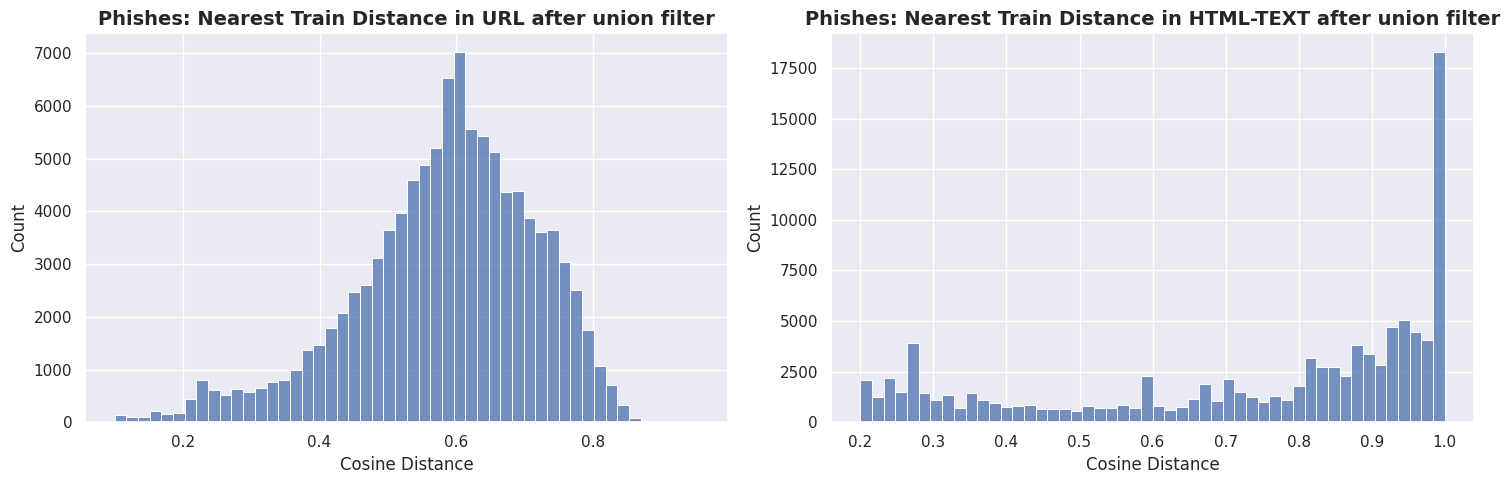

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
union_test_min_dist = {
    'url': test_min_dist['url'][~test_min_dist['url']['test_sha256'].isin(union_filter)],
    'html': test_min_dist['html'][~test_min_dist['html']['test_sha256'].isin(union_filter)]
}
for i, feat_type in enumerate(['url', 'html']):
    sns.histplot(union_test_min_dist[feat_type]['min_distance'], bins=50, kde=False, stat='count', ax=axes[i])
    feat_type = "html-text" if feat_type == "html" else feat_type
    axes[i].set_title(f'{class_type.capitalize()}: Nearest Train Distance in {feat_type.upper()} after union filter', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cosine Distance')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Histogram of collection period after diversity filter (union)

After filtering, loaded phishes has 232528 samples in train set
After filtering, loaded phishes has 103904 samples in test set
After filtering, Positive Class ratio: 0.3088


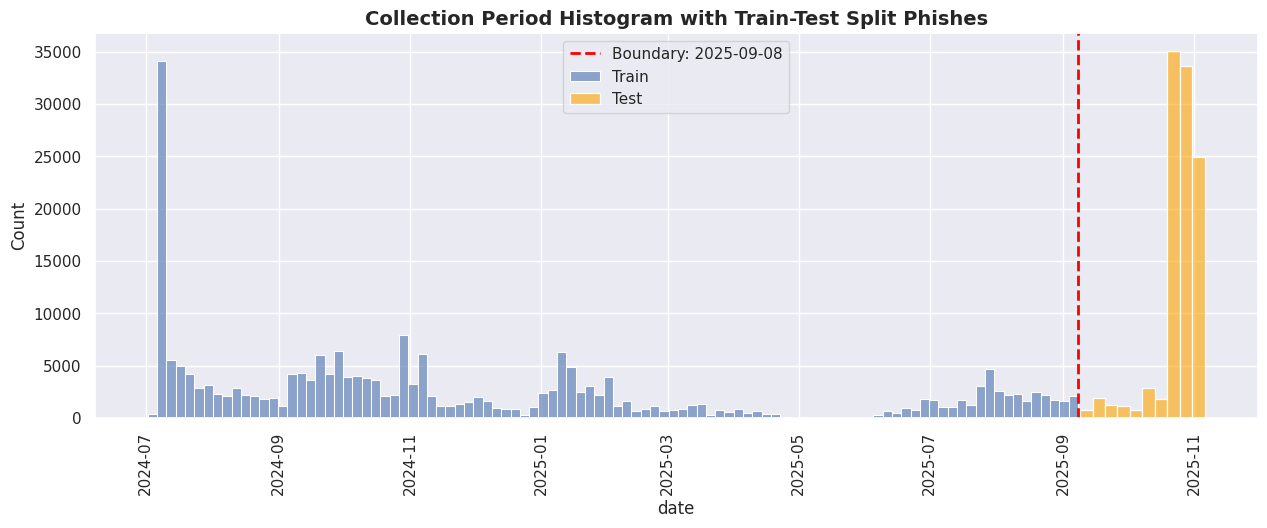

In [16]:
train_df = train_df.loc[~train_df['sha256'].isin(union_filter)]
test_df = test_df.loc[~test_df['sha256'].isin(union_filter)]
print(f"After filtering, loaded {class_type} has {len(train_df)} samples in train set")
print(f"After filtering, loaded {class_type} has {len(test_df)} samples in test set")
print(f"After filtering, Positive Class ratio: {len(test_df) / (len(test_df) + len(train_df)):.4f}")
time_analysis(class_type, train_df, test_df)

### Save the list of sha256's to be dropped from test

In [ ]:
import dill
from pathlib import Path

leakage_filtered_dir = Path(".data/splitting/leakage_filtered")
leakage_filtered_dir.mkdir(parents=True, exist_ok=True)
leakage_filtered_path = leakage_filtered_dir / "phish.pkl"

with open(leakage_filtered_path, "wb") as f:
    dill.dump(union_filter, f)

print(f"{len(union_filter)} samples to filter based on union of URL and HTML distance thresholds saved in pickle file {leakage_filtered_path}")

45817 samples to filter based on union of URL and HTML distance thresholds saved in pickle file .data/splitting/leakage_filtered/phish.pkl


### Benigns

#### Histogram of collection period before diversity filter

Loading samples of benign:: 100%|██████████| 276731/276731 [07:46<00:00, 593.76it/s] 


Loaded benigns dataframe with shape: (276731, 8)


Loading samples of benign:: 100%|██████████| 119733/119733 [03:54<00:00, 511.60it/s]


Loaded benigns dataframe with shape: (119733, 8)


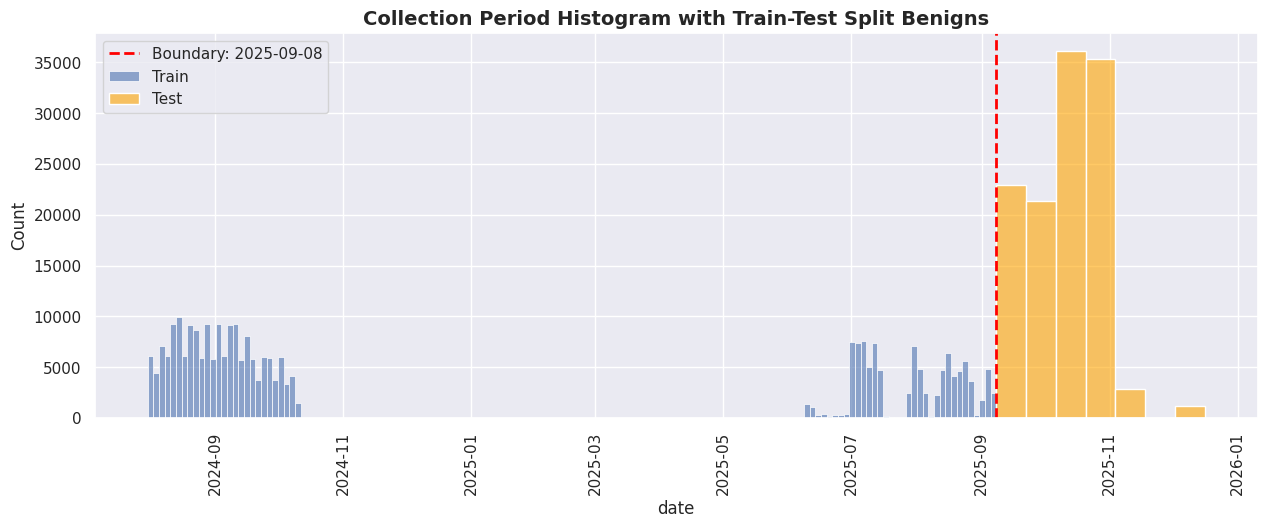

In [15]:
class_type = 'benigns'
train_df = load_df(dir['train'][class_type])
print(f"Loaded {class_type} dataframe with shape: {train_df.shape}")
test_df = load_df(dir['test'][class_type])
print(f"Loaded {class_type} dataframe with shape: {test_df.shape}")
time_analysis(class_type, train_df, test_df)

#### Nearest train distance distributions

In [16]:
import dill
import pandas as pd

class_type = 'benigns'
test_min_dist = {'url': None, 'html': None}

for feat_type in ['url', 'html']:
    nn_path = dir['nn'][class_type][feat_type]
    with open(nn_path, 'rb') as f:
        min_dist = dill.load(f)
        df = pd.DataFrame.from_dict(min_dist, orient='index', columns=['nearest_train', 'min_distance']).reset_index()
        df = df.rename(columns={'index': 'test_sha256'})
        df['class_type'] = class_type
        test_min_dist[feat_type] = df

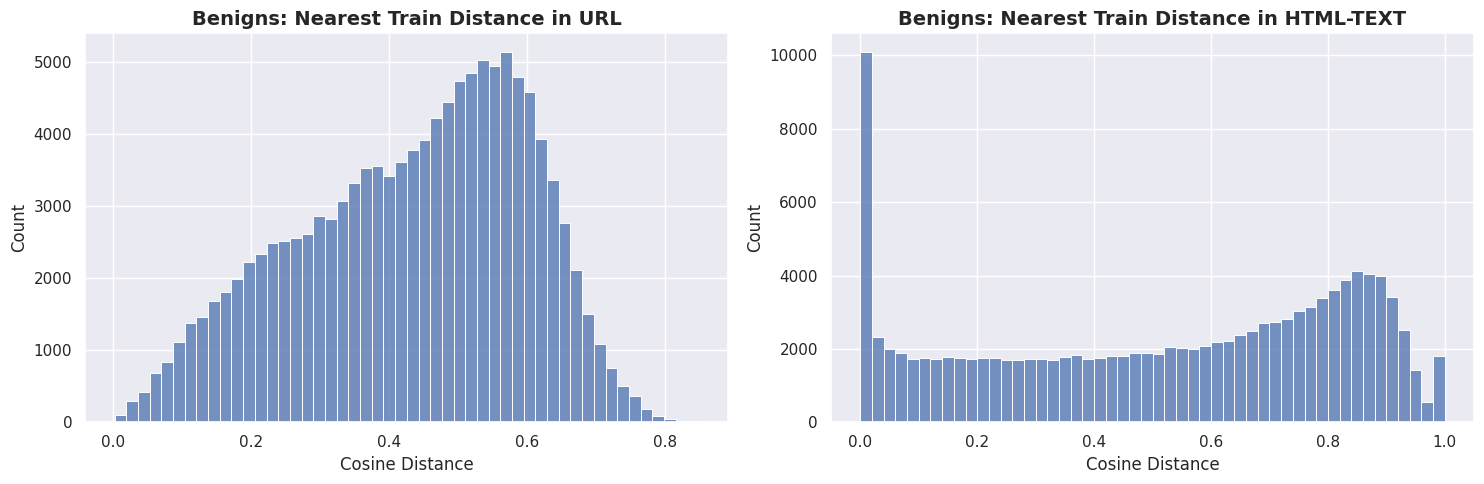

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i, feat_type in enumerate(['url', 'html']):
    sns.histplot(test_min_dist[feat_type]['min_distance'], bins=50, kde=False, stat='count', ax=axes[i])
    feat_type = "html-text" if feat_type == "html" else feat_type
    axes[i].set_title(f'{class_type.capitalize()}: Nearest Train Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cosine Distance')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Sample html text cosine distances & levenshtein ratios

In [14]:
import pandas as pd

threshs = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
n_samples = 100

samples = None
for thresh in threshs:
    threshold_samples = (
        test_min_dist['html'][test_min_dist['html']['min_distance'] <= thresh]
        .sort_values('min_distance', ascending=False)
        .head(n_samples)[['class_type', 'test_sha256', 'nearest_train', 'min_distance']]
    )
    threshold_samples.columns = ['class_type', 'test_sha256', 'train_sha256', 'cosine_distance']
    threshold_samples['threshold'] = thresh
    threshold_samples['levenshtein_ratio'] = threshold_samples.apply(get_distance, axis=1)
    threshold_samples['median_cosine_distance'] = threshold_samples['cosine_distance'].median()
    threshold_samples['median_levenshtein_ratio'] = threshold_samples['levenshtein_ratio'].median()   

    samples = threshold_samples if samples is None else pd.concat([samples, threshold_samples])

samples = samples.reset_index(drop=True)

samples.to_csv(f'./data/final-{class_type}-test-samples-for-filtering.csv', index=False)

samples

,class_type,test_sha256,train_sha256,cosine_distance,threshold,levenshtein_ratio,median_cosine_distance,median_levenshtein_ratio
0,benigns,b10af114f31b03abccda4613f09026e3e32a780a1ad5ec...,40f3568433d03c32d52aa1103ea08f9c142fd458db9d1f...,0.099995,0.1,0.727403,0.099430,0.737187
1,benigns,6a907365195b8ade19b7cb00074fd84734fd633d534bee...,1a00adaaf0b2d363ec66e1fc8a54af1d9f60f94fe199d1...,0.099979,0.1,0.685656,0.099430,0.737187
2,benigns,58bbd7664874b8d567cfab9dbd091319416036e060cc6e...,beb21cc72ce2c100d88579e99379d00e68b6f8dadf33e9...,0.099977,0.1,0.856617,0.099430,0.737187
3,benigns,0cbfaea0f5719cdddd66b6a413067f29c260571b5d5bce...,38bf2d6770c0955d71e3c8c79d7f07039bde9eb1e8cd2d...,0.099971,0.1,0.684690,0.099430,0.737187
4,benigns,b5ad2083428d108f60c8289847f6360b10cedc43624883...,ce914ed499736dcd49117009f070a0cdc0fd10da653a9d...,0.099970,0.1,0.836423,0.099430,0.737187
...,...,...,...,...,...,...,...,...
895,benigns,6bb7f4274c074f70152cc0fb102251e0d4844c507ddd51...,329ac19108b701f80618ec14bafe271a154b2699e0913e...,0.298702,0.3,0.718976,0.299347,0.463453
896,benigns,7bede3acf0ee707856f1bd0cc6dc24d1687e578e747cc1...,a62b82ac3eaa49110e23d229d8cda9eb2e016dae2aa470...,0.298702,0.3,0.655041,0.299347,0.463453
897,benigns,eb3527d3918898a0bb7f5435b4d2a0c0befd9b98c48a31...,15084952344bb70c300db76d65b6c5409034d96938e8d3...,0.298693,0.3,0.799626,0.299347,0.463453
898,benigns,0f12afd7dfdd433ff3e131eae90c274fb3415a3f717ee8...,5c4739a7aab7e78322ef772e4c4c8ce846a24587536dc3...,0.298691,0.3,0.449850,0.299347,0.463453


Recommended cosine distance cut-offs:
- url: above 0.1
- html: above 0.2

In [18]:
url_filter = set(test_min_dist['url'].loc[test_min_dist['url']['min_distance'] < 0.1, 'test_sha256'].to_list())
html_filter = set(test_min_dist['html'].loc[test_min_dist['html']['min_distance'] < 0.2, 'test_sha256'].to_list())
intersection_filter = url_filter.intersection(html_filter)
union_filter = url_filter.union(html_filter)

print(f"Number of samples to filter based on URL distance threshold 0.1: {len(url_filter)}")
print(f"Number of samples to filter based on HTML distance threshold 0.2: {len(html_filter)}")
print("-" * 100)
print(f"Number of samples to filter based on both URL and HTML distance thresholds: {len(intersection_filter)}")
print(f"Number of test samples will reduce from {len(test_min_dist['html'])} to {len(test_min_dist['html']) - len(intersection_filter)}")
print("-" * 100)
print(f"Number of samples to filter based on either URL or HTML distance thresholds: {len(union_filter)}")
print(f"Number of test samples will reduce from {len(test_min_dist['html'])} to {len(test_min_dist['html']) - len(union_filter)}")
print("-" * 100)

Number of samples to filter based on URL distance threshold 0.1: 3176
Number of samples to filter based on HTML distance threshold 0.2: 26798
----------------------------------------------------------------------------------------------------
Number of samples to filter based on both URL and HTML distance thresholds: 1501
Number of test samples will reduce from 119733 to 118232
----------------------------------------------------------------------------------------------------
Number of samples to filter based on either URL or HTML distance thresholds: 28473
Number of test samples will reduce from 119733 to 91260
----------------------------------------------------------------------------------------------------


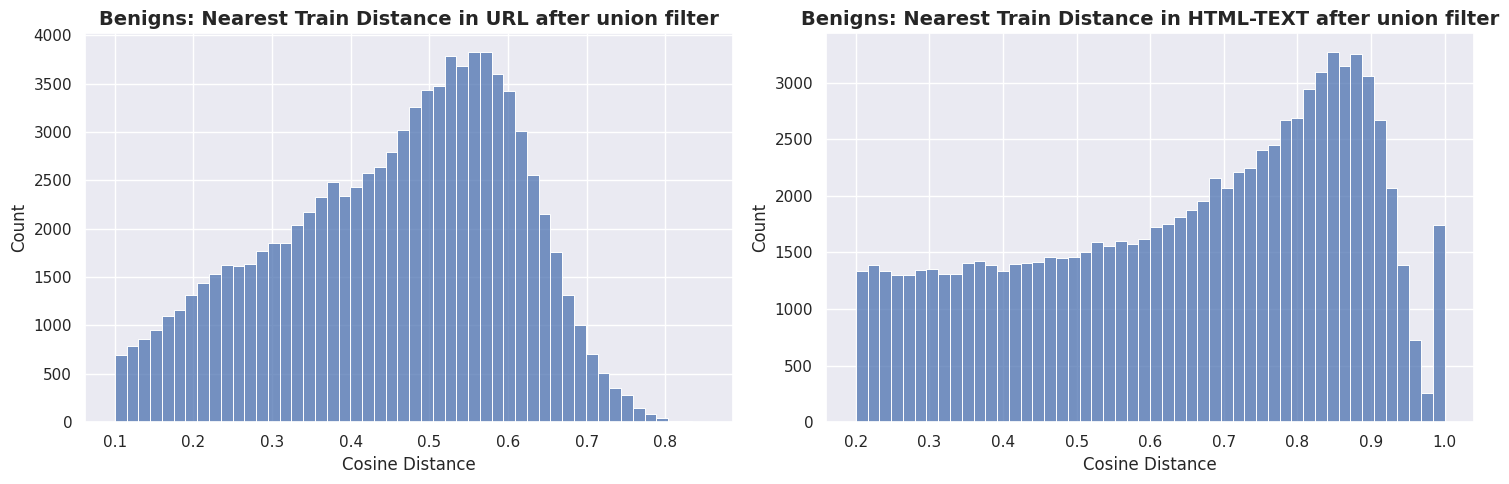

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
union_test_min_dist = {
    'url': test_min_dist['url'][~test_min_dist['url']['test_sha256'].isin(union_filter)],
    'html': test_min_dist['html'][~test_min_dist['html']['test_sha256'].isin(union_filter)]
}
for i, feat_type in enumerate(['url', 'html']):
    sns.histplot(union_test_min_dist[feat_type]['min_distance'], bins=50, kde=False, stat='count', ax=axes[i])
    feat_type = "html-text" if feat_type == "html" else feat_type
    axes[i].set_title(f'{class_type.capitalize()}: Nearest Train Distance in {feat_type.upper()} after union filter', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cosine Distance')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Histogram of collection period after diversity filter (union)

After filtering, loaded benigns has 276731 samples in train set
After filtering, loaded benigns has 91260 samples in test set
After filtering, Positive Class ratio: 0.2480


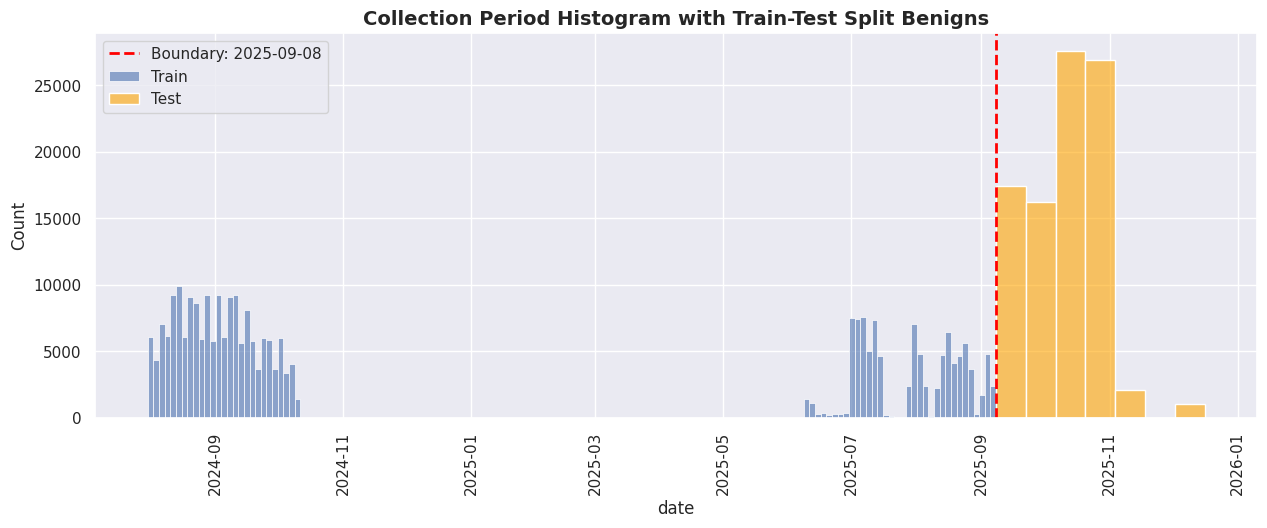

In [20]:
train_df = train_df.loc[~train_df['sha256'].isin(union_filter)]
test_df = test_df.loc[~test_df['sha256'].isin(union_filter)]
print(f"After filtering, loaded {class_type} has {len(train_df)} samples in train set")
print(f"After filtering, loaded {class_type} has {len(test_df)} samples in test set")
print(f"After filtering, Positive Class ratio: {len(test_df) / (len(test_df) + len(train_df)):.4f}")
time_analysis(class_type, train_df, test_df)

### Save the list of sha256's to be dropped from test

In [ ]:
import dill
from pathlib import Path

leakage_filtered_dir = Path(".data/splitting/leakage_filtered")
leakage_filtered_dir.mkdir(parents=True, exist_ok=True)
leakage_filtered_path = leakage_filtered_dir / "benign.pkl"

with open(leakage_filtered_path, "wb") as f:
    dill.dump(union_filter, f)

print(f"{len(union_filter)} samples to filter based on union of URL and HTML distance thresholds saved in pickle file {leakage_filtered_path}")

### Summary

In [19]:
test_ratio = (103904 + 91260) / (103904 + 91260 + 232528 + 276731)
print(f"Overall test ratio after filtering: {test_ratio:.4f}")
positive_class_ratio_in_train = 232528 / (232528 + 276731)
print(f"Positive class ratio in train set after filtering: {positive_class_ratio_in_train:.4f}")
positive_class_ratio_in_test = 103904 / (103904 + 91260)
print(f"Positive class ratio in test set after filtering: {positive_class_ratio_in_test:.4f}")

Overall test ratio after filtering: 0.2771
Positive class ratio in train set after filtering: 0.4566
Positive class ratio in test set after filtering: 0.5324
